In [106]:
# ============================================================
# LIGUE 1 EXPECTED GOALS (xG) MODEL — LOGISTIC REGRESSION
# ============================================================
# WHAT:    This notebook builds, tunes, and evaluates an xG model
#          from shot event data, then compares results to Understat.
# WHY:     To create an interpretable and calibrated model that
#          predicts the probability a shot results in a goal.
# HOW:     Uses scikit-learn logistic regression with L2 regularization,
#          group-aware splitting by match, isotonic calibration,
#          and feature engineering (distance, angle, etc.).
# ============================================================

# --- Core Python / Data Handling ---
import os
import numpy as np
import pandas as pd

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# --- Machine Learning ---
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    brier_score_loss
)

# --- Saving Artifacts ---
import joblib

# --- Reproducibility ---
RANDOM_STATE = 42

# --- Pitch dimensions (meters) ---
PITCH_LEN_X = 106.0  # length
PITCH_LEN_Y = 68.0   # width

# --- Model artifact output directory ---
SAVE_DIR = "artifacts/xg_model_ligue1"
os.makedirs(SAVE_DIR, exist_ok=True)


In [107]:
import soccerdata as sd

# ============================================================
# DATA INGESTION — FETCHING SHOT DATA FROM UNDERSTAT (LIGUE 1)
# ============================================================
# FLOW:
# 1) (Optional) Check which leagues Understat supports via soccerdata API.
#    This helps confirm the league identifier string (e.g., 'FRA-Ligue 1').
# 2) Create an Understat scraper object for Ligue 1 without specifying a season,
#    then query all available seasons for that league.
# 3) Define the LEAGUES and SEASONS of interest — here we set Ligue 1 (France)
#    and the 2024/25 season.
# 4) Create a new scraper instance tied to those league/season settings.
# 5) Call `read_shot_events()` to retrieve a full DataFrame of event-level shot data
#    for all matches in the selected league and season(s). Each row represents
#    a single shot, with columns like coordinates, shooter, body part, and outcome.
# ============================================================

# 1) See available Understat leagues (optional debug)
# print(sd.Understat.available_leagues())  # should include 'FRA-Ligue 1'

# 2) Create scraper for Ligue 1, check seasons
us = sd.Understat(leagues="FRA-Ligue 1")
seasons_df = us.read_seasons()
# print(seasons_df.head())
# print("All seasons available:", seasons_df.index.get_level_values('season').unique().tolist())

# 3) Set league and season(s) of interest
LEAGUES = ['FRA-Ligue 1']  # France Ligue 1
SEASONS = [2024]           # 2024/25 season

# 4) Create scraper for specified league + season
us = sd.Understat(leagues=LEAGUES, seasons=SEASONS)

# 5) Retrieve all shot events for the given settings
shots = us.read_shot_events()  # returns event-level shot DataFrame
# print(shots.head())
# print(shots.columns.tolist())
# print(shots.shape)


[08/14/25 12:13:43] INFO     Saving cached data to C:\Users\paulo\soccerdata\data\Understat          ]8;id=50325;file://c:\Users\paulo\OneDrive\Documents\Football_analyst_portfolio\Expected_Goal_Model\expected_goal\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=901939;file://c:\Users\paulo\OneDrive\Documents\Football_analyst_portfolio\Expected_Goal_Model\expected_goal\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    INFO     No seasons provided. Will retrieve data for the last 5 seasons.         ]8;id=637227;file://c:\Users\paulo\OneDrive\Documents\Football_analyst_portfolio\Expected_Goal_Model\expected_goal\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=204704;file://c:\Users\paulo\OneDrive\Documents\Football_analyst_portfolio\Expected_Goal_Model\expected_goal\Lib\site-packages\soccerdata\_common.py#475\475]8;;\

                    INFO     Saving cached data to C:\Users\paulo\soccerdata\data\Understat          ]8;id=336284;file://c:\Users\paulo\OneDrive\Documents\Football_analyst_portfolio\Expected_Goal_Model\expected_goal\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=809968;file://c:\Users\paulo\OneDrive\Documents\Football_analyst_portfolio\Expected_Goal_Model\expected_goal\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [108]:
# ============================================================
# DATA PREPARATION — STANDARDIZING COLUMN NAMES
# ============================================================
# WHAT:    Creates a working copy of the raw shot DataFrame and 
#          renames columns to a consistent schema.
# WHY:     Understat column names can vary slightly between datasets
#          (e.g., "x" vs "location_x", "result" vs "outcome").
#          Standardizing early ensures the rest of the pipeline runs 
#          without breaking due to mismatched column names.
# HOW:     Build a mapping dict (col_map) conditionally, checking for
#          known variants, and apply via .rename().
# ============================================================

# 1) Work on a copy to avoid modifying the raw 'shots' DataFrame in place
df_shots = shots.copy()

# 2) Create an empty mapping dictionary to hold renaming rules
col_map = {}

# --- Coordinate columns ---
# Understat sometimes uses "x"/"y", but older exports may have "location_x"/"location_y".
if "x" in df_shots.columns and "y" in df_shots.columns:
    # Already standardized — no changes needed
    col_map.update({})
elif "location_x" in df_shots.columns and "location_y" in df_shots.columns:
    # Map location_x -> x, location_y -> y
    col_map.update({"location_x": "x", "location_y": "y"})
else:
    # Fail early if neither variant is found
    raise KeyError("Couldn't find shot coordinate columns. Inspect df.columns and adjust mapping.")

# --- Outcome column ---
# Understat may call this "outcome" or "result".
if "outcome" in df_shots.columns:
    pass  # Already correct
elif "result" in df_shots.columns:
    col_map.update({"result": "outcome"})
else:
    raise KeyError("Couldn't find an outcome/result column. Inspect df.columns and adjust mapping.")

# --- Optional categorical columns ---
# Keep these for later feature engineering if available.
if "body_part" in df_shots.columns:
    col_map.update({"body_part": "BodyPart"})  # Normalize casing
if "situation" in df_shots.columns:
    col_map.update({"situation": "play_type"})  # Match internal naming

# 3) Apply the renaming
df_shots = df_shots.rename(columns=col_map)

# 4) Quick sanity check on key columns
df_shots[["x", "y", "outcome"]].head(3)


x  \
league      season game                                    team     player                   
FRA-Ligue 1 2425   2024-08-16 Le Havre-Paris Saint Germain Le Havre Abdoulaye Touré  0.792   
                                                                    Abdoulaye Touré  0.785   
                                                                    Antoine Joujou   0.853   

                                                                                         y  \
league      season game                                    team     player                   
FRA-Ligue 1 2425   2024-08-16 Le Havre-Paris Saint Germain Le Havre Abdoulaye Touré  0.642   
                                                                    Abdoulaye Touré  0.374   
                                                                    Antoine Joujou   0.662   

                                                                                          outcome  
league      season game                                    team     player                         
FRA-Ligue 1 2425   2024-08-16 Le Havre-Paris Saint Germain Le Havre Abdoulaye Touré  Blocked Shot  
                                                                    Abdoulaye Touré    Saved Shot  
                                                                    Antoine Joujou   Blocked Shot

In [109]:
# ============================================================
#   CLEAN LABELS, IDENTIFY PENALTIES, AND CREATE TARGETS
# ============================================================
# WHAT:    Fix missing categorical labels, detect unlabeled penalties,
#          create target (goal flag), and set constant penalty xG values.
# WHY:     Ensures consistency in features/targets before modeling,
#          and corrects for known quirks in Understat data.
# HOW:     1) Detect penalties via location pattern.
#          2) Fill missing categoricals.
#          3) Create binary target (goal_flag).
#          4) Add penalty flag + constant xG for aggregation.
# ============================================================

# --- 1) Detect unlabeled penalties ---
# Understat sometimes leaves 'play_type' NaN for penalties.
# Known penalty spot coords ≈ (x=0.885, y=0.500) in normalized units.
# Relax the tolerance slightly to catch rounding differences.
# Also exclude own goals (based on 'outcome' text).
TOL = 1e-3
pen_mask = (
    df_shots["play_type"].isna()
    & (np.abs(df_shots["x"] - 0.885) < TOL)
    & (np.abs(df_shots["y"] - 0.500) < TOL)
    & (~df_shots["outcome"].astype(str).str.lower().str.contains("own", na=False))
)

# Set play_type to "Penalty" for detected cases
df_shots.loc[pen_mask, "play_type"] = "Penalty"

# --- 2) Fill missing categorical values robustly ---
# Convert to string first to avoid NaN issues during fill.
for c in ["play_type", "BodyPart"]:
    if c in df_shots.columns:
        df_shots[c] = df_shots[c].astype(str).fillna("Unknown")

# --- 3) Create binary target: goal_flag ---
# 1 = outcome is exactly "goal" (case-insensitive)
# 0 = all other outcomes
df_shots["goal_flag"] = df_shots["outcome"].astype(str).str.lower().eq("goal").astype(int)

# --- 4) Add penalty flag and constant penalty xG ---
# Penalty flag: True if play_type is "Penalty"
df_shots["is_penalty"] = df_shots["play_type"].astype(str).str.lower().eq("penalty")

# Assign a constant penalty xG value (default 0.76, adjust for league-specific rate if available)
PEN_XG_CONST = 0.76
df_shots["xg_penalty_const"] = np.where(df_shots["is_penalty"], PEN_XG_CONST, np.nan)

# --- 5) Quick sanity check ---
print(
    "Rows total:", len(df_shots),
    "| penalties:", df_shots["is_penalty"].sum(),
    "| goal rate:", df_shots["goal_flag"].mean().round(3)
)


Rows total: 7647 | penalties: 114 | goal rate: 0.116


The shots DataFrame contains 7647 shots and 888 goals (11.6%).

The dataset contains the following columns: ['league_id', 'season_id', 'game_id', 'date', 'shot_id', 'team_id', 'player_id', 'assist_player_id', 'assist_player', 'xg', 'x', 'y', 'minute', 'BodyPart', 'play_type', 'outcome', 'goal_flag', 'is_penalty', 'xg_penalty_const']

Unique values in the 'play_type' column: ['Open Play' 'Set Piece' 'From Corner' 'Penalty' 'Direct Freekick']

Unique values in the 'BodyPart' column: ['Left Foot' 'Right Foot' '<NA>']

Unique values in the 'outcome' column: <StringArray>
['Blocked Shot', 'Saved Shot', 'Goal', 'Missed Shot', 'Shot On Post',
 'Own Goal']
Length: 6, dtype: string

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7647 entries, ('FRA-Ligue 1', '2425', '2024-08-16 Le Havre-Paris Saint Germain', 'Le Havre', 'Abdoulaye Touré') to ('FRA-Ligue 1', '2425', '2025-05-17 Strasbourg-Le Havre', 'Strasbourg', 'Sékou Mara')
Data columns (total 19 columns):
 #   Column            Non-Null C

assist_player_id    1975
assist_player       1975
xg_penalty_const    7533
dtype: int64

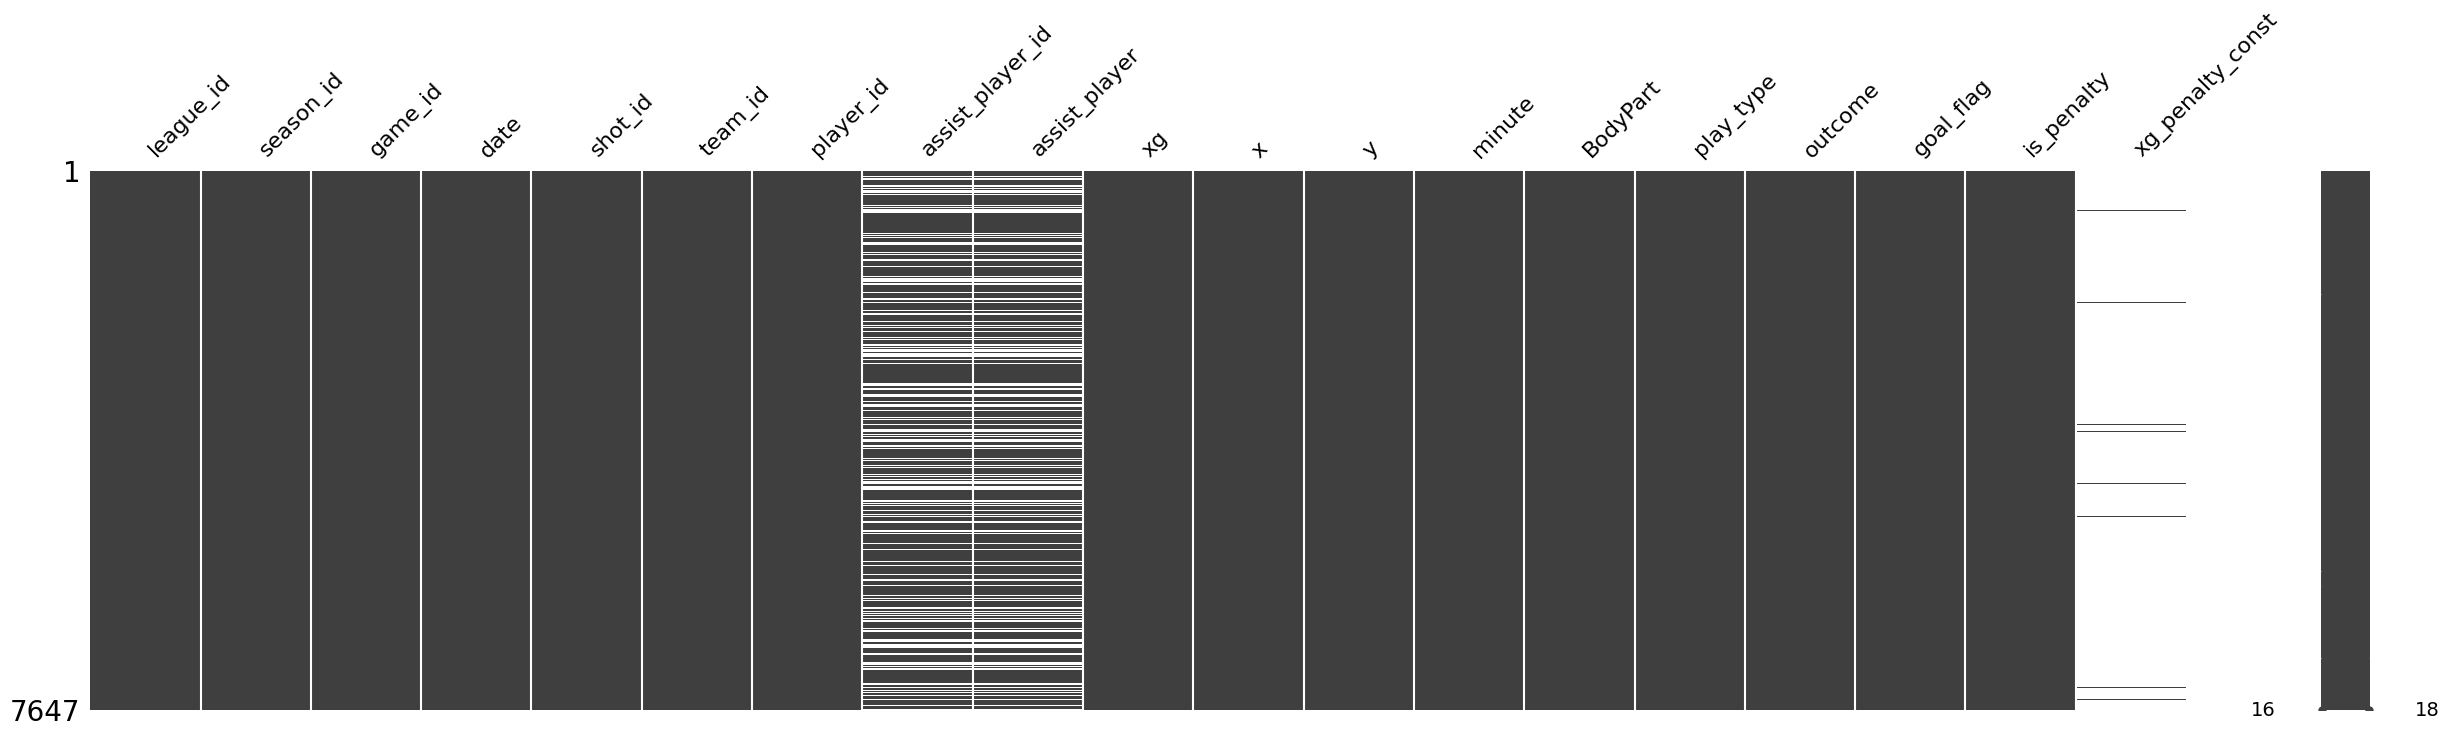

In [110]:
# =========================================================
#   Further Data Exploration
# =========================================================

# View basic statistical summary of numeric columns
# df_shots.describe()

# Display first 5 rows of the raw DataFrame
# df_shots.head()

# Display last 5 rows of the raw DataFrame
# df_shots.tail()

# Check the shape (rows, columns) of the DataFrame
# print(df_shots.shape)


# =========================================================
#   Print statements about dataset
# =========================================================

# Count total shots
count_shots = len(df_shots)

# Count total goals (including own goals)
count_goals = len(
    df_shots[(df_shots['outcome'] == 'Goal') | (df_shots['outcome'] == 'owngoal')]
)

# List all column names
cols = list(df_shots)

# Get unique values for key categorical columns
vals_play_type  = df_shots['play_type'].unique()
vals_body_part  = df_shots['BodyPart'].unique()
vals_outcome    = df_shots['outcome'].unique()

# Print high-level dataset info
print(f"The shots DataFrame contains {count_shots} shots and {count_goals} goals "
      f"({round(100 * count_goals / count_shots, 1)}%).\n")
print(f"The dataset contains the following columns: {cols}\n")
print(f"Unique values in the 'play_type' column: {vals_play_type}\n")
print(f"Unique values in the 'BodyPart' column: {vals_body_part}\n")
print(f"Unique values in the 'outcome' column: {vals_outcome}\n")


# =========================================================
#   Value counts & Missing data inspection
# =========================================================

# Count each play type, including NaN
df_shots['play_type'].value_counts(dropna=False)

# Inspect coordinates (x, y) for rows with missing play_type
df_shots[df_shots['play_type'].isna()][['x', 'y']].describe()

# Show shot outcomes and their frequency
df_shots.groupby(['outcome']).outcome.count()

# Print DataFrame info (column types, non-null counts)
df_shots.info()


# =========================================================
#   Missing values visualization and stats
# =========================================================
import missingno as msno

# Visualize missing values for each column
msno.matrix(df_shots, figsize=(30, 7))

# Count missing values per column
null_value_stats = df_shots.isnull().sum(axis=0)

# Show only columns with missing values
null_value_stats[null_value_stats != 0]


In [111]:
import os

# ============================================================
# STEP — SAVE CLEANED SHOT DATA LOCALLY
# ============================================================
# WHAT:    Store the cleaned and standardized shot dataset as a CSV file.
# WHY:     Persisting the processed dataset allows reuse in later steps
#          without re-running data ingestion and cleaning (saves time).
# HOW:     1) Create the target directory if it doesn't exist.
#          2) Export DataFrame to CSV without the index column.
# ============================================================

# 1) Ensure the output directory exists; create if necessary.
#    exist_ok=True avoids errors if the directory already exists.
os.makedirs("data/shots", exist_ok=True)

# 2) Write the cleaned DataFrame to CSV.
#    index=False prevents saving the pandas index as an extra column.
df_shots.to_csv("data/shots/ligue1_2024_shots.csv", index=False)

# 3) Confirm file write.
print("Wrote data/shots/ligue1_2024_shots.csv")


Wrote data/shots/ligue1_2024_shots.csv


In [112]:
# ============================================================
# CONFIGURATION — FILE PATHS & CONSTANTS
# ============================================================
# WHAT:    Define paths and key constants for model/data handling.
# WHY:     Centralizing configs makes it easier to modify without
#          changing multiple parts of the code.
# ============================================================

# Path to cleaned shot event dataset (change if using different league/season)
DATA_PATH = "data/shots/ligue1_2024_shots.csv"

# Directory to save model artifacts (trained model, scalers, encoders, etc.)
SAVE_DIR  = "artifacts/xg_model_ligue1"

# Pitch dimensions in meters (used for distance/angle calculations)
PITCH_LEN_X = 106.0  # length of pitch
PITCH_LEN_Y = 68.0   # width of pitch

# ============================================================
# STEP — LOAD DATA & PERFORM BASIC SANITY CHECKS
# ============================================================

# Load the pre-cleaned shots dataset into a DataFrame
df_shots = pd.read_csv(DATA_PATH)

def sanity_check(df: pd.DataFrame):
    """
    Perform basic quality checks on the shot event dataset.

    WHAT:
        - Prints dataset shape.
        - Verifies that required columns ('x', 'y', 'outcome') exist.
        - Displays min/max coordinate ranges for x and y.
        - Shows top outcome categories by frequency.
    WHY:
        - Ensures data has expected structure before proceeding with feature
          engineering and model training.
        - Helps catch ingestion/mapping errors early.
    """
    print("="*60)
    
    # 1) Dataset dimensions
    print(f"Shape: {df.shape}")
    
    # 2) Required column presence check
    req = ["x", "y", "outcome"]
    miss = [c for c in req if c not in df.columns]
    assert not miss, f"Missing required columns: {miss}"
    
    # 3) Coordinate value ranges (useful to confirm normalization/scaling)
    print("x range:", float(df["x"].min()), "→", float(df["x"].max()))
    print("y range:", float(df["y"].min()), "→", float(df["y"].max()))
    
    # 4) Outcome distribution — top 10 categories
    print("Outcome counts (top):")
    print(df["outcome"].astype(str).value_counts().head(10))
    
    print("="*60)

# Run initial sanity check
sanity_check(df_shots)


Shape: (7647, 19)
x range: 0.0069999998807907 → 0.995
y range: 0.035 → 0.899000015258789
Outcome counts (top):
outcome
Missed Shot     2614
Blocked Shot    2068
Saved Shot      1896
Goal             888
Shot On Post     158
Own Goal          23
Name: count, dtype: int64


In [113]:
# =========================================================
# COORDINATE NORMALIZATION (Understat-safe)
# ---------------------------------------------------------
# 
# 1) Work on a copy of the DataFrame (avoid in-place edits).
# 2) Optionally flip the y-axis (Understat y grows downward;
#    most plotting/geometry logic assumes y grows upward).
# 3) Clamp x,y into [0,1] to guard against bad/edge values.
# 4) Return the normalized DataFrame and re-check basic stats.
# =========================================================
def normalize_xy(df, x_col="x", y_col="y", flip_y=True):
    # 1) Avoid mutating the caller's DataFrame
    out = df.copy()
    
    # 2) Flip y so "up" is larger (common for plotting & geometry)
    if flip_y:
        out[y_col] = 1.0 - out[y_col]
    
    # 3) Safety clamps: keep coordinates inside the valid 0..1 box
    out[x_col] = out[x_col].clip(0, 1)
    out[y_col] = out[y_col].clip(0, 1)
    
    # 4) Hand back normalized coordinates
    return out

# Apply normalization to shot coordinates
df_shots = normalize_xy(df_shots, x_col="x", y_col="y", flip_y=True)

# Sanity: confirm expected ranges and label distribution post-normalization
sanity_check(df_shots)


Shape: (7647, 19)
x range: 0.0069999998807907 → 0.995
y range: 0.10099998474121097 → 0.965
Outcome counts (top):
outcome
Missed Shot     2614
Blocked Shot    2068
Saved Shot      1896
Goal             888
Shot On Post     158
Own Goal          23
Name: count, dtype: int64


In [114]:
import pandas as pd

# ============================================================
#         PITCH UTILITIES
# ============================================================
# WHAT:    Helper functions to:
#          1) Convert normalized Understat coordinates (0–1 scale) 
#             into Metrica-style meter coordinates.
#          2) Provide pitch-plot coordinates for consistent 
#             shot visualizations.
# WHY:     - Maintain a consistent pitch style for all plots.
#          - Support plotting in both centered (tactical) view and 
#            bottom-left-origin (mplsoccer) view.
# HOW:     - understat_to_metrica(...) transforms coordinates.
# ============================================================

import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Directory to save generated figures
FIG_DIR = os.path.join(SAVE_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# Define pitch dimensions in meters
L = 105.0   # Pitch length (adjustable if dataset uses slightly different size)
W = 68.0    # Pitch width

def understat_to_metrica(df, x_col='x', y_col='y', L=105.0, W=68.0):
    """
    Convert normalized Understat coordinates to:
      - Metrica-style centered meters: 
            x_m ∈ [-L/2, +L/2], y_m ∈ [-W/2, +W/2]
      - Plotting coordinates for mplsoccer (origin bottom-left):
            x_plot ∈ [0, L], y_plot ∈ [0, W]

    Parameters:
        df (pd.DataFrame) : Input dataframe with normalized coords (0..1)
        x_col, y_col      : Column names for normalized x/y
        L, W              : Pitch length and width in meters

    Returns:
        pd.DataFrame : Copy of df with new columns:
                       ['x_m', 'y_m', 'x_plot', 'y_plot']
    """
    out = df.copy()
    
    # 1) Convert normalized coords to centered meters
    out['x_m'] = (out[x_col] - 0.5) * L
    out['y_m'] = (out[y_col] - 0.5) * W
    
    # 2) Convert to bottom-left origin for plotting
    out['x_plot'] = out['x_m'] + L/2
    out['y_plot'] = out['y_m'] + W/2
    
    return out

# --- Apply the conversion to the shots DataFrame ---
df_met = understat_to_metrica(df_shots, 'x', 'y', L=L, W=W)

# --- Quick inspection of transformed coordinates ---
print(df_met[['x', 'y', 'x_m', 'y_m']].head())  # First few rows
print("x_m range:", df_met['x_m'].min(), "to", df_met['x_m'].max())  # Range in meters
print("y_m range:", df_met['y_m'].min(), "to", df_met['y_m'].max())


       x      y        x_m        y_m
0  0.792  0.358  30.659997  -9.655998
1  0.785  0.626  29.925000   8.567999
2  0.853  0.338  37.065003 -11.015998
3  0.925  0.322  44.625000 -12.104002
4  0.870  0.691  38.850000  12.988000
x_m range: -51.76500001251698 to 51.975
y_m range: -27.132001037597654 to 31.619999999999997


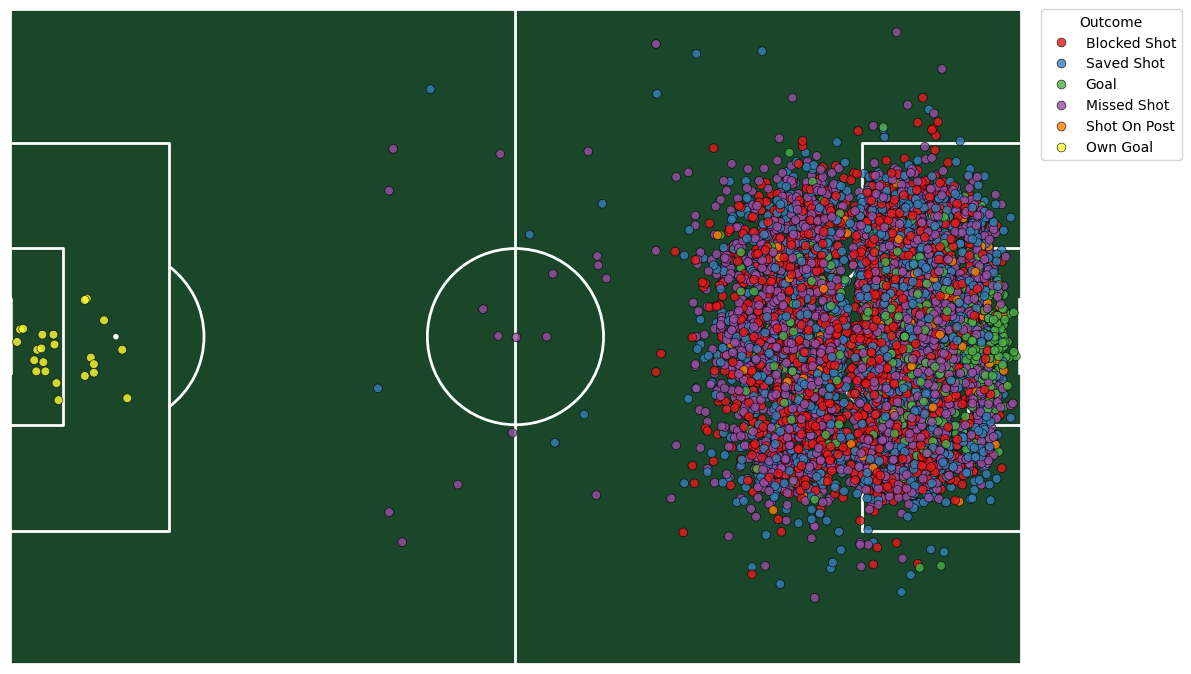

In [115]:
from mplsoccer import Pitch 
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
#   PITCH SETUP & SHOT VISUALIZATION
# ============================================================


# 1) Create a Pitch object with custom size and styling
#    - pitch_type='custom' allows explicit length/width
#    - dark green background (#1a472a) makes outcome colors pop
#    - white lines for clear visibility
pitch = Pitch(
    pitch_type='custom',
    pitch_length=L, pitch_width=W,
    pitch_color='#1a472a',   # dark green pitch
    line_color='white'       # white markings
)

# 2) Draw the pitch on a Matplotlib figure/axes
fig, ax = pitch.draw(figsize=(12, 8))

# Set visible pitch area (full length & width)
ax.set_xlim(0, L)
ax.set_ylim(0, W)

# 3) Scatter plot shots
#    - hue='outcome' colors points by result (goal, miss, etc.)
#    - alpha=0.8 for semi-transparency
#    - s=40 controls point size
#    - edgecolor='black' outlines points for visibility
sns.scatterplot(
    data=df_met,
    x='x_plot', y='y_plot',
    hue='outcome',
    alpha=0.8,
    s=40,
    edgecolor='black',
    ax=ax,
    palette='Set1'  # high-contrast categorical colors
)

# 4) Legend configuration
#    - Place legend outside pitch (upper left, shifted right)
#    - White background for readability
ax.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    title='Outcome',
    facecolor='white'
)

# Axis labels for clarity
ax.set_xlabel('Meters')
ax.set_ylabel('Meters')

# 5) Adjust layout and display plot
plt.tight_layout()
plt.show()


Goals: 888 | Non-goals: 6759


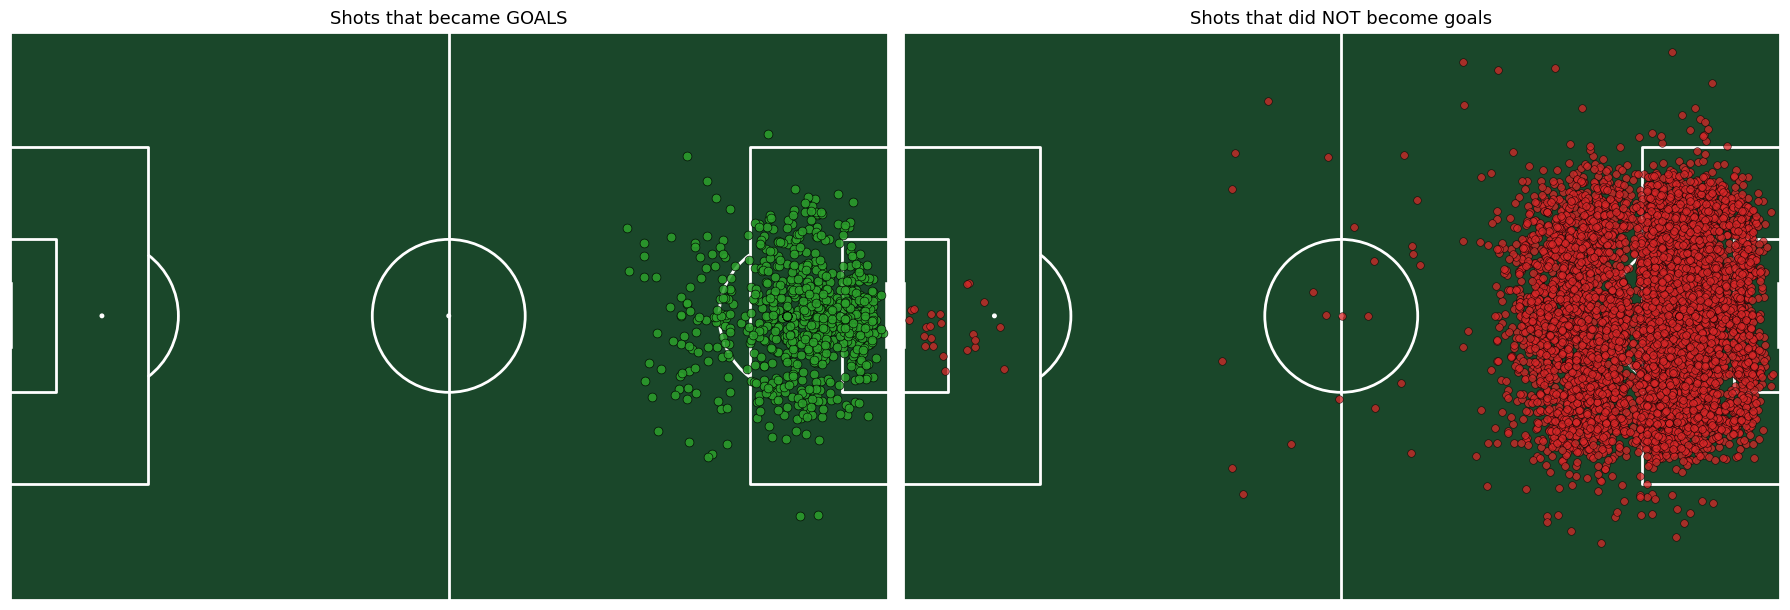

Saved combined figure -> shots_goals_vs_nongoals.png
Saved separate panels -> shots_goals_only.png and shots_nongoals_only.png


In [116]:
# --- Split shots into goals and non-goals ------------------------------------
# If 'goal_flag' column doesn't exist, create it from the 'outcome' column (1=goal, 0=not goal)
if 'goal_flag' not in df_met.columns:
    df_met['goal_flag'] = df_met['outcome'].str.lower().eq('goal').astype(int)

# Create separate DataFrames for goals and non-goals
df_goals    = df_met[df_met['goal_flag'] == 1].copy()
df_nongoals = df_met[df_met['goal_flag'] == 0].copy()

print(f"Goals: {len(df_goals)} | Non-goals: {len(df_nongoals)}")

# --- Visualization: two full-pitch plots side-by-side -----------------------
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns

# Common pitch settings for both plots
pitch_kwargs = dict(
    pitch_type='custom',
    pitch_length=L, pitch_width=W,
    pitch_color='#1a472a',   # dark green pitch background
    line_color='white'       # white pitch lines
)

# Create a 1x2 figure for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for ax in axes:
    Pitch(**pitch_kwargs).draw(ax=ax)
    ax.set_xlim(0, L)
    ax.set_ylim(0, W)

# Left panel: plot all goal shots in green
sns.scatterplot(
    data=df_goals, x='x_plot', y='y_plot',
    color='#2ca02c',  # green points
    s=40, alpha=0.85, edgecolor='black', ax=axes[0]
)
axes[0].set_title('Shots that became GOALS', fontsize=13)
axes[0].set_xlabel('Meters')
axes[0].set_ylabel('Meters')

# Right panel: plot all non-goal shots in red
sns.scatterplot(
    data=df_nongoals, x='x_plot', y='y_plot',
    color='#d62728',  # red points
    s=30, alpha=0.75, edgecolor='black', ax=axes[1]
)
axes[1].set_title('Shots that did NOT become goals', fontsize=13)
axes[1].set_xlabel('Meters')
axes[1].set_ylabel('')

# Save the combined figure
plt.tight_layout()
plt.savefig('shots_goals_vs_nongoals.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved combined figure -> shots_goals_vs_nongoals.png")

# --- Optional: also save the two panels separately --------------------------

# Goals only
fig_g, ax_g = plt.subplots(figsize=(9, 7))
Pitch(**pitch_kwargs).draw(ax=ax_g)
ax_g.set_xlim(0, L)
ax_g.set_ylim(0, W)
sns.scatterplot(
    data=df_goals, x='x_plot', y='y_plot',
    color='#2ca02c', s=40, alpha=0.85, edgecolor='none', ax=ax_g
)
ax_g.set_title('Goals', fontsize=13)
ax_g.set_xlabel('Meters')
ax_g.set_ylabel('Meters')
plt.tight_layout()
plt.savefig('shots_goals_only.png', dpi=300, bbox_inches='tight')
plt.close(fig_g)

# Non-goals only
fig_ng, ax_ng = plt.subplots(figsize=(9, 7))
Pitch(**pitch_kwargs).draw(ax=ax_ng)
ax_ng.set_xlim(0, L)
ax_ng.set_ylim(0, W)
sns.scatterplot(
    data=df_nongoals, x='x_plot', y='y_plot',
    color='#d62728', s=40, alpha=0.75, edgecolor='black', ax=ax_ng
)
ax_ng.set_title('Non-goals', fontsize=13)
ax_ng.set_xlabel('Meters')
ax_ng.set_ylabel('Meters')
plt.tight_layout()
plt.savefig('shots_nongoals_only.png', dpi=300, bbox_inches='tight')
plt.close(fig_ng)

print("Saved separate panels -> shots_goals_only.png and shots_nongoals_only.png")


[08/14/25 12:13:48] WARNING  C:\Users\paulo\AppData\Local\Temp\ipykernel_20376\1111905123.py:8:     ]8;id=930636;file://C:\Users\paulo\miniconda3\Lib\warnings.py\warnings.py]8;;\:]8;id=723798;file://C:\Users\paulo\miniconda3\Lib\warnings.py#112\112]8;;\
                             DeprecationWarning: is_categorical_dtype is deprecated and will be                    
                             removed in a future version. Use isinstance(dtype,                                    
                             pd.CategoricalDtype) instead                                                          
                               if pd.api.types.is_categorical_dtype(df_met['play_type']):                          
                                                                                                                   

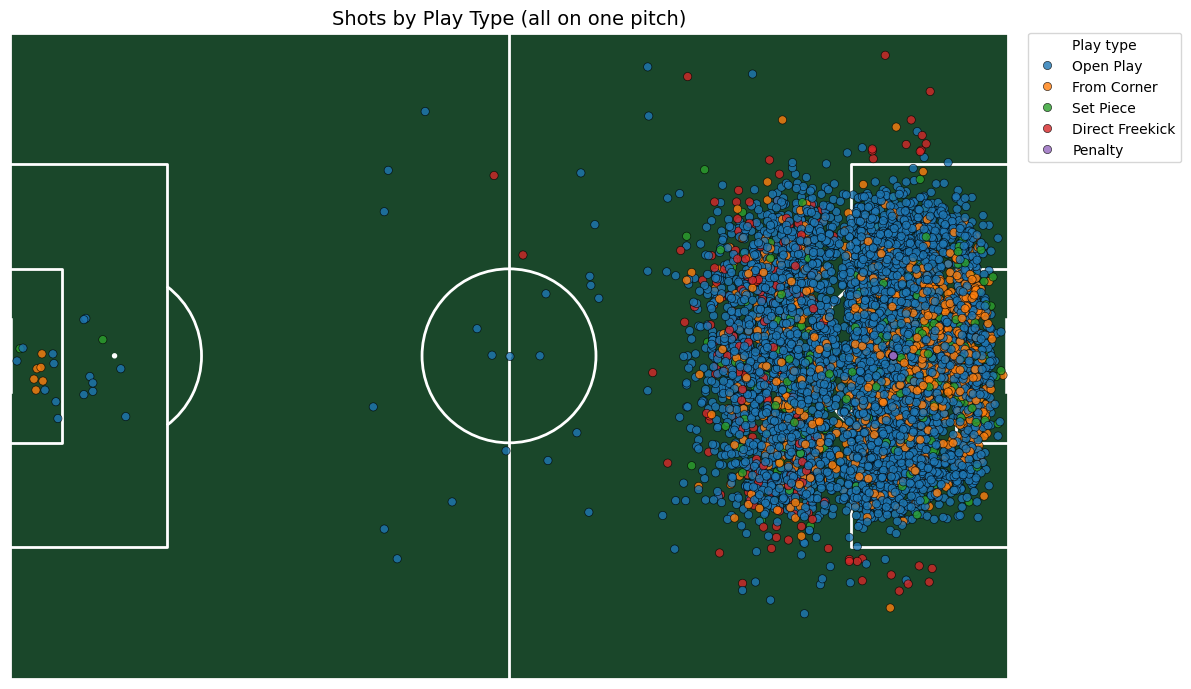

In [117]:
from mplsoccer import Pitch
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Ensure 'play_type' exists as a tidy, non-null categorical
# ------------------------------------------------------------
if pd.api.types.is_categorical_dtype(df_met['play_type']):
    # Add 'Unknown' category if missing, then fill NaNs
    if 'Unknown' not in df_met['play_type'].cat.categories:
        df_met['play_type'] = df_met['play_type'].cat.add_categories(['Unknown'])
    df_met['play_type'] = df_met['play_type'].fillna('Unknown')
else:
    # Coerce to string and replace NaNs with 'Unknown'
    df_met['play_type'] = df_met['play_type'].fillna('Unknown').astype(str)

# ------------------------------------------------------------
# Order categories by frequency (for consistent legend order)
# ------------------------------------------------------------
play_order = df_met['play_type'].value_counts().index.tolist()
df_met['play_type'] = pd.Categorical(df_met['play_type'], categories=play_order, ordered=True)

# ------------------------------------------------------------
# Build a color map large enough for all categories
# ------------------------------------------------------------
palette = (
    sns.color_palette('tab10', n_colors=len(play_order))
    if len(play_order) <= 10
    else sns.color_palette('tab20', n_colors=len(play_order))
)
color_map = {cat: palette[i] for i, cat in enumerate(play_order)}

# ------------------------------------------------------------
# Draw a full custom-sized pitch (meters) and set view limits
# ------------------------------------------------------------
pitch = Pitch(
    pitch_type='custom',
    pitch_length=L, pitch_width=W,
    pitch_color='#1a472a',   # dark green so colors pop
    line_color='white'
)
fig, ax = pitch.draw(figsize=(12, 8))
ax.set_xlim(0, L)
ax.set_ylim(0, W)

# ------------------------------------------------------------
# Scatter all shots, colored by 'play_type'
# ------------------------------------------------------------
sns.scatterplot(
    data=df_met,
    x='x_plot', y='y_plot',
    hue='play_type',
    palette=color_map,
    s=35, alpha=0.8, edgecolor='black',
    ax=ax
)

# ------------------------------------------------------------
# Legend, labels, and title
# ------------------------------------------------------------
ax.legend(
    title='Play type',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=True,
    facecolor='white'
)
ax.set_xlabel('Meters')
ax.set_ylabel('Meters')
ax.set_title('Shots by Play Type (all on one pitch)', fontsize=14)

# ------------------------------------------------------------
# Save figure (no interactive display/print to keep output silent)
# ------------------------------------------------------------
plt.tight_layout()
plt.savefig('shots_by_play_type_full_pitch.png', dpi=300, bbox_inches='tight')

# plt.show()  # (output intentionally disabled)
# print("Saved figure -> shots_by_play_type_full_pitch.png")  # (output intentionally disabled)


Saved figure -> shots_by_body_part_full_pitch.png


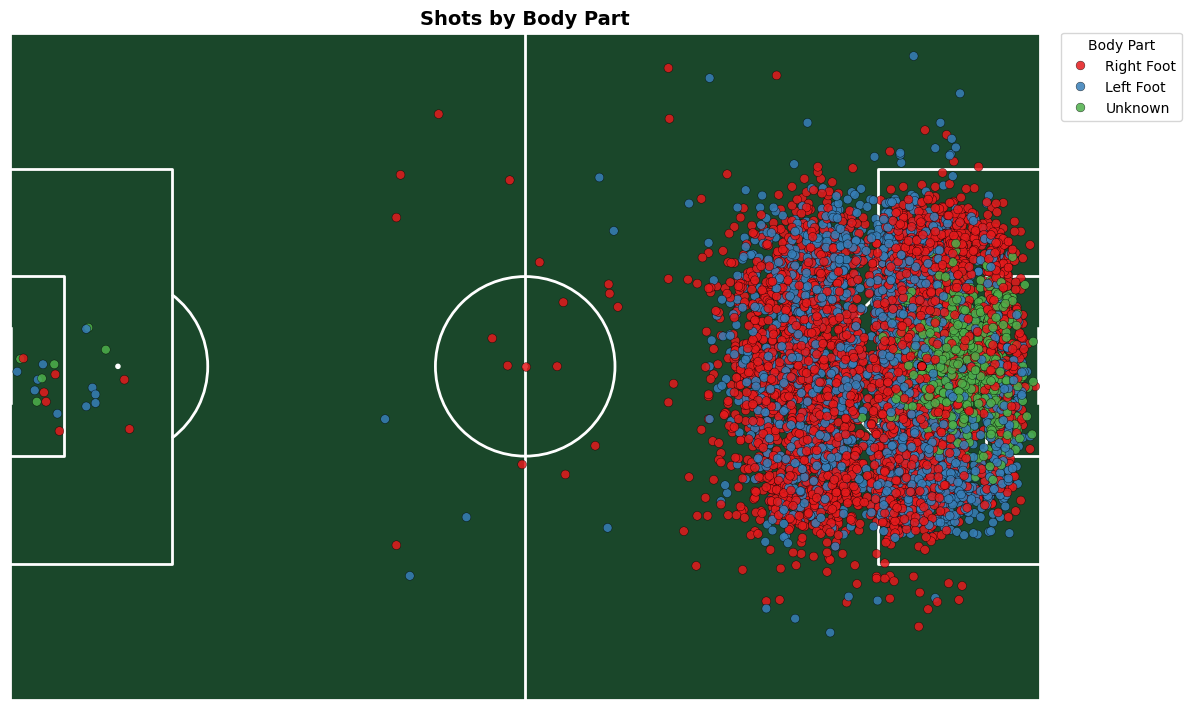

In [118]:
from mplsoccer import Pitch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure BodyPart is cleaned
df_met['BodyPart'] = df_met['BodyPart'].fillna('Unknown').astype(str)

# Order categories by frequency
bp_order = df_met['BodyPart'].value_counts().index.tolist()
df_met['BodyPart'] = pd.Categorical(df_met['BodyPart'], categories=bp_order, ordered=True)

# Bright high-contrast color palette
palette = sns.color_palette('Set1', n_colors=len(bp_order)) if len(bp_order) <= 9 \
          else sns.color_palette('hls', n_colors=len(bp_order))
color_map = {cat: palette[i] for i, cat in enumerate(bp_order)}

# Draw full pitch
pitch = Pitch(
    pitch_type='custom',
    pitch_length=L, pitch_width=W,
    pitch_color='#1a472a',   # dark green so markers pop
    line_color='white'
)
fig, ax = pitch.draw(figsize=(12, 8))
ax.set_xlim(0, L); ax.set_ylim(0, W)

# Scatter plot with hue by BodyPart
sns.scatterplot(
    data=df_met,
    x='x_plot', y='y_plot',
    hue='BodyPart',
    palette=color_map,
    s=40, alpha=0.85, edgecolor='black', linewidth=0.3,  # black edge for visibility
    ax=ax
)

# Legend styling
ax.legend(
    title='Body Part',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=True,
    facecolor='white'
)
ax.set_xlabel('Meters'); ax.set_ylabel('Meters')
ax.set_title('Shots by Body Part', fontsize=14, fontweight='bold')

# Save figure
plt.tight_layout()
plt.savefig('shots_by_body_part_full_pitch.png', dpi=300, bbox_inches='tight')
#plt.show()

print("Saved figure -> shots_by_body_part_full_pitch.png")


In [119]:
# Remove own goals (robust match for 'own')
df_shots = df_shots[~df_shots["outcome"].astype(str).str.lower().str.contains("own", na=False)]

# remove penalties for training (recommended)
if "play_type" in df_shots.columns:
    before = len(df_shots)
    df_shots = df_shots[~df_shots["play_type"].astype(str).str.contains("pen", case=False, na=False)]
    print(f"Removed penalties: {before - len(df_shots)} rows")

print("After filtering:")
print(df_shots["outcome"].astype(str).value_counts().head(10))


Removed penalties: 5827 rows
After filtering:
outcome
Missed Shot     787
Blocked Shot    509
Saved Shot      313
Goal            148
Shot On Post     40
Name: count, dtype: int64


In [120]:
# ============================================================
#       GEOMETRY FEATURES (DISTANCE, ANGLE, TRANSFORMS)
# ============================================================
# WHAT:    Add robust geometric features and low-risk transforms.
# WHY:     Distance & angle are the strongest event-only predictors for xG.
#          Transforms (log, sin/cos) capture non-linearity without overfitting.
# HOW:     Compute distance to goal center, opening angle between posts,
#          vertical offset, log distance, sin/cos(angle), header interaction.
# ============================================================

def add_geometry_features(df, x_col="x", y_col="y", pitch_width_m=68.0, goal_width_m=7.32):
    out = df.copy()
    goal_x, goal_y = 1.0, 0.5
    # Normalize half-goal width in [0,1] pitch coords
    g = (goal_width_m / pitch_width_m) / 2.0

    # Clamp to [0,1] for safety
    x = out[x_col].clip(0, 1)
    y = out[y_col].clip(0, 1)

    # Distance to goal center
    out["dist_to_center"] = np.hypot(goal_x - x, goal_y - y)

    # Opening angle between posts; wrap to [-pi, pi] for stability
    left_post_y  = goal_y - g
    right_post_y = goal_y + g
    ang = np.arctan2(right_post_y - y, goal_x - x) - np.arctan2(left_post_y - y, goal_x - x)
    out["open_angle"] = np.abs((ang + np.pi) % (2 * np.pi) - np.pi)

    # Vertical offset from center line
    out["y_from_center"] = np.abs(y - goal_y)

    # Helpful transforms
    out["log_dist"]  = np.log1p(out["dist_to_center"])
    out["cos_angle"] = np.cos(out["open_angle"])
    out["sin_angle"] = np.sin(out["open_angle"])

    # Header interaction
    out["is_header"] = out.get("BodyPart", pd.Series(index=out.index, dtype=object)).astype(str).str.lower().str.contains("head").astype(int)
    out["angle_x_header"] = out["open_angle"] * out["is_header"]

    return out

df_shots = add_geometry_features(df_shots, "x", "y")

print("Added geometry features:",
      ["dist_to_center","open_angle","y_from_center","log_dist","cos_angle","sin_angle","is_header","angle_x_header"])
# Quick sanity check
tmp = df_shots.assign(is_goal=df_shots["goal_flag"])
print(
    tmp.groupby("is_goal")[["dist_to_center","open_angle","y_from_center"]]
       .mean()
       .rename(index={0:"Not goal", 1:"Goal"})
)


Added geometry features: ['dist_to_center', 'open_angle', 'y_from_center', 'log_dist', 'cos_angle', 'sin_angle', 'is_header', 'angle_x_header']
          dist_to_center  open_angle  y_from_center
is_goal                                            
Not goal        0.168848    0.650997       0.088606
Goal            0.111019    1.043705       0.059324


In [121]:
# ============================================================
#     DESIGN MATRIX, GROUP-AWARE SPLIT, TUNING & CALIBRATION
# ============================================================
# WHAT:    Build X/y, split data without match leakage, tune C on log-loss,
#          and calibrate probabilities with isotonic regression.
# WHY:     Grouped splits avoid inflated metrics; calibration makes
#          probability sums meaningful for xG aggregates.
# HOW:     GroupShuffleSplit (train/val/test), GridSearchCV over C using
#          StratifiedGroupKFold, then CalibratedClassifierCV on a val hold-out.
# ============================================================

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, GridSearchCV
from sklearn.calibration import calibration_curve

# Choose groups for leakage-safe splits
# =========================================================
if "game_id" in df_shots.columns:
    groups_all = df_shots["game_id"]
elif "match_id" in df_shots.columns:
    groups_all = df_shots["match_id"]
else:
    # As a last resort, group by (home_team, date) if available; else default to row index (not ideal)
    groups_all = pd.factorize(
        df_shots.get("match_id", df_shots.index)
    )[0]

# Train on non-penalty shots only
# (penalties are handled separately in production)
model_df = df_shots.loc[~df_shots["is_penalty"]].copy()
y_all = model_df["goal_flag"].astype(int)

# Feature columns
num_cols = ["x","y","dist_to_center","open_angle","y_from_center","log_dist","cos_angle","sin_angle","angle_x_header"]
cat_cols = [c for c in ["BodyPart","play_type"] if c in model_df.columns]

X_all = model_df[num_cols + cat_cols].copy()
groups_model = groups_all.loc[model_df.index]

# 70/30 split for train/val/test (group-aware)
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_STATE)
trval_idx, te_idx = next(gss.split(X_all, y_all, groups=groups_model))
X_trval, X_te = X_all.iloc[trval_idx], X_all.iloc[te_idx]
y_trval, y_te = y_all.iloc[trval_idx], y_all.iloc[te_idx]
g_trval = groups_model.iloc[trval_idx]

#Split trainval into train/validation  (≈52.5/17.5 of total) for calibration
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=RANDOM_STATE)  # ~ 52.5/17.5 split inside 70
tr_idx, val_idx = next(gss2.split(X_trval, y_trval, groups=g_trval))
X_tr, X_val = X_trval.iloc[tr_idx], X_trval.iloc[val_idx]
y_tr, y_val = y_trval.iloc[tr_idx], y_trval.iloc[val_idx]

# Preprocess (keep OHE sparse for scalability)
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols) if cat_cols else ("cat", "drop", [])
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Base classifier: L2, saga supports sparse matrices well
base = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l2", solver="saga", max_iter=2000, n_jobs=-1, random_state=RANDOM_STATE
    ))
])


# Tune C via grouped CV on negative log-loss
param_grid = {"clf__C": np.logspace(-3, 2, 10)}
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="neg_log_loss",
    cv=cv,
    n_jobs=-1,
    refit=True
)
gs.fit(X_tr, y_tr, **({"groups": g_trval.iloc[tr_idx]} if hasattr(gs, "fit") else {}))
best_pipe = gs.best_estimator_
print("Best C (neg_log_loss):", gs.best_params_["clf__C"])

# Fit on train, then isotonic calibration on validation
best_pipe.fit(X_tr, y_tr)
cal = CalibratedClassifierCV(estimator=best_pipe, method="isotonic", cv="prefit")
cal.fit(X_val, y_val)

# Evaluate on the held-out test set
y_proba_te = cal.predict_proba(X_te)[:, 1]
print(f"TEST — AUC: {roc_auc_score(y_te, y_proba_te):.4f} | LogLoss: {log_loss(y_te, y_proba_te):.4f} | Brier: {brier_score_loss(y_te, y_proba_te):.4f}")

# Reliability table (quantile bins)
frac_pos, mean_pred = calibration_curve(y_te, y_proba_te, n_bins=20, strategy="quantile")
rel_df = pd.DataFrame({"mean_pred": mean_pred, "frac_pos": frac_pos})
display(rel_df.head())


Best C (neg_log_loss): 0.1668100537200059


[08/14/25 12:14:04] WARNING  c:\Users\paulo\OneDrive\Documents\Football_analyst_portfolio\Expected_ ]8;id=171216;file://C:\Users\paulo\miniconda3\Lib\warnings.py\warnings.py]8;;\:]8;id=672443;file://C:\Users\paulo\miniconda3\Lib\warnings.py#112\112]8;;\
                             Goal_Model\expected_goal\Lib\site-packages\sklearn\calibration.py:330:                
                              FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will                
                             be removed in 1.8. You can use                                                        
                             CalibratedClassifierCV(FrozenEstimator(estimator)) instead.                           
                               warnings.warn(                                                                      
                                                                                                                   

TEST — AUC: 0.7270 | LogLoss: 0.3436 | Brier: 0.0789


,mean_pred,frac_pos
0,0.000000,0.000000
1,0.025252,0.033058
2,0.029369,0.049587
3,0.066667,0.113636
4,0.130687,0.153846


In [122]:
# ============================================================
#        OUT-OF-FOLD (OOF) PROBABILITIES
# ============================================================
# WHAT:    Produce per-shot probabilities without training on the same
#          match (no leakage). Use these for fair seasonal aggregates.
# WHY:     When comparing to Understat or summing to league totals,
#          in-sample predictions can make you look over-confident.
# HOW:     5-fold StratifiedGroupKFold; rebuild pipe with best C; write
#          OOF probabilities back to df_shots; add penalties via constant.
# ============================================================

from sklearn.model_selection import StratifiedGroupKFold

oof_pipe = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l2", solver="saga", C=best_C, max_iter=2000, n_jobs=-1, random_state=RANDOM_STATE
    ))
])

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_proba = np.full(shape=(len(X_all),), fill_value=np.nan, dtype=float)

for fold, (tr_cv, va_cv) in enumerate(cv.split(X_all, y_all, groups=groups_model), start=1):
    X_tr_cv, X_va_cv = X_all.iloc[tr_cv], X_all.iloc[va_cv]
    y_tr_cv, y_va_cv = y_all.iloc[tr_cv], y_all.iloc[va_cv]
    oof_pipe.fit(X_tr_cv, y_tr_cv)
    oof_proba[va_cv] = oof_pipe.predict_proba(X_va_cv)[:, 1]
    print(f"Fold {fold} done. Val size: {len(va_cv)}")

assert np.isfinite(oof_proba).all(), "OOF predictions contain NaNs."

# Attach OOF probs to the non-penalty subset
model_df = model_df.copy()
model_df["model_xG_oof"] = oof_proba

# Write back to full df_shots; penalties via constant
df_shots = df_shots.copy()
df_shots["model_xG_oof"] = np.nan
df_shots.loc[model_df.index, "model_xG_oof"] = model_df["model_xG_oof"]
df_shots["model_xG_with_pen"] = np.where(df_shots["is_penalty"], PEN_XG_CONST, df_shots["model_xG_oof"])

print("Attached 'model_xG_oof' and 'model_xG_with_pen' to df_shots.")


Fold 1 done. Val size: 344
Fold 2 done. Val size: 369
Fold 3 done. Val size: 363
Fold 4 done. Val size: 377
Fold 5 done. Val size: 344
Attached 'model_xG_oof' and 'model_xG_with_pen' to df_shots.


In [123]:
# ============================================================
# LEAGUE TABLE COMPARISON (SEASON TOTALS)
# ============================================================
# WHAT:    Compare your model's xG (OOF + penalty const) vs Understat's xG
#          and actual goals at the team/season level.
# WHY:     Team aggregates reveal systematic bias (under-/over-estimation).
# HOW:     Group by team; compute sums and residuals.
# ============================================================

team_col = "team_id"                # change if needed
understat_xg_col = "xg"
understat_goal_col = "goal_flag"     # actual goals

missing = [c for c in [team_col, understat_xg_col, understat_goal_col] if c not in df_shots.columns]
if missing:
    print("⚠️ Missing expected columns in df_shots:", missing)
else:
    league_table = (
        df_shots.groupby(team_col)
        .agg(
            games_played = (team_col, "count"),
            goals        = (understat_goal_col, "sum"),
            understat_xG = (understat_xg_col, "sum"),
            model_xG     = ("model_xG_with_pen", "sum")
        )
        .reset_index()
    )

    league_table = league_table.sort_values("model_xG", ascending=False)
    league_table["goals_minus_model_xG"]     = (league_table["goals"] - league_table["model_xG"]).round(2)
    league_table["goals_minus_understat_xG"] = (league_table["goals"] - league_table["understat_xG"]).round(2)
    league_table["model_xG"]     = league_table["model_xG"].round(2)
    league_table["understat_xG"] = league_table["understat_xG"].round(2)
    league_table["goals"]        = league_table["goals"].astype(int)

    display(league_table)


,team_id,games_played,goals,understat_xG,model_xG,goals_minus_model_xG,goals_minus_understat_xG
9,174,123,8,14.53,12.10,-4.10,-6.53
17,282,108,11,12.79,11.83,-0.83,-1.79
15,241,126,15,13.93,11.80,3.20,1.07
7,170,115,9,10.96,9.96,-0.96,-1.96
8,171,97,9,10.00,9.67,-0.67,-1.00
4,166,106,5,8.73,8.40,-3.40,-3.73
13,210,105,7,8.23,8.21,-1.21,-1.23
2,163,98,8,7.77,7.96,0.04,0.23
0,160,112,9,9.30,7.83,1.17,-0.30
1,161,109,8,9.55,7.60,0.40,-1.55


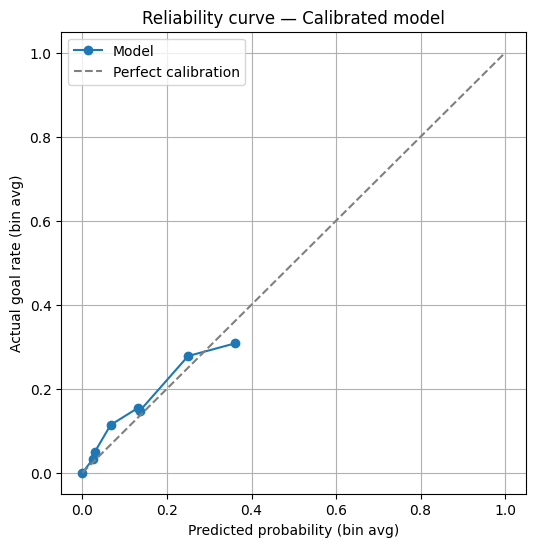

In [124]:
# ============================================================
# RELIABILITY CURVE (CALIBRATION PLOT)
# ============================================================
# WHAT:    Visual check that predicted probabilities match observed rates.
# WHY:     Good AUC without calibration still leads to biased xG sums.
# HOW:     Plot mean_pred vs frac_pos with a perfect-calibration reference.
# ============================================================

plt.figure(figsize=(6,6))
plt.plot(rel_df["mean_pred"], rel_df["frac_pos"], marker='o', label="Model")
plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Perfect calibration")
plt.xlabel("Predicted probability (bin avg)")
plt.ylabel("Actual goal rate (bin avg)")
plt.title("Reliability curve — Calibrated model")
plt.legend()
plt.grid(True)
plt.show()


In [125]:
# ============================================================
# MATCH-BY-MATCH COMPARISON
# ============================================================
# WHAT:    Compare per-match totals between Understat and your model.
# WHY:     Drill from season-level bias down to specific games.
# HOW:     Group by match_id and sum xG + goals.
# ============================================================

match_id_col = "game_id"        # change if needed
understat_xg_col = "xg"  # Understat xG column
understat_goal_col = "goal_flag"  # actual goals

missing = [c for c in [match_id_col, understat_xg_col, understat_goal_col, "model_xG_with_pen"] if c not in df_shots.columns]
if missing:
    print("⚠️ Missing expected columns in df_shots:", missing)
else:
    match_table = (
        df_shots.groupby(match_id_col)
        .agg(
            goals        = (understat_goal_col, "sum"),
            understat_xG = (understat_xg_col, "sum"),
            model_xG     = ("model_xG_with_pen", "sum")
        )
        .reset_index()
    )

    match_table["goals_minus_model_xG"]     = (match_table["goals"] - match_table["model_xG"]).round(2)
    match_table["goals_minus_understat_xG"] = (match_table["goals"] - match_table["understat_xG"]).round(2)

    match_table["model_xG"]     = match_table["model_xG"].round(2)
    match_table["understat_xG"] = match_table["understat_xG"].round(2)
    match_table["goals"]        = match_table["goals"].astype(int)

    display(match_table.sort_values("model_xG", ascending=False).head(20))


,game_id,goals,understat_xG,model_xG,goals_minus_model_xG,goals_minus_understat_xG
212,28263,2,2.44,2.27,-0.27,-0.44
180,28231,2,1.66,1.95,0.05,0.34
116,28165,1,1.57,1.61,-0.61,-0.57
129,28179,0,1.17,1.61,-1.61,-1.17
174,28225,1,0.80,1.58,-0.58,0.20
172,28223,0,0.70,1.50,-1.50,-0.70
296,28347,0,1.14,1.47,-1.47,-1.14
52,28100,0,1.13,1.42,-1.42,-1.13
274,28325,2,1.60,1.36,0.64,0.40
157,28207,2,1.79,1.34,0.66,0.21


Pearson r:  0.833 (p=1.89e-79)
Spearman ρ: 0.855 (p=6.4e-88)


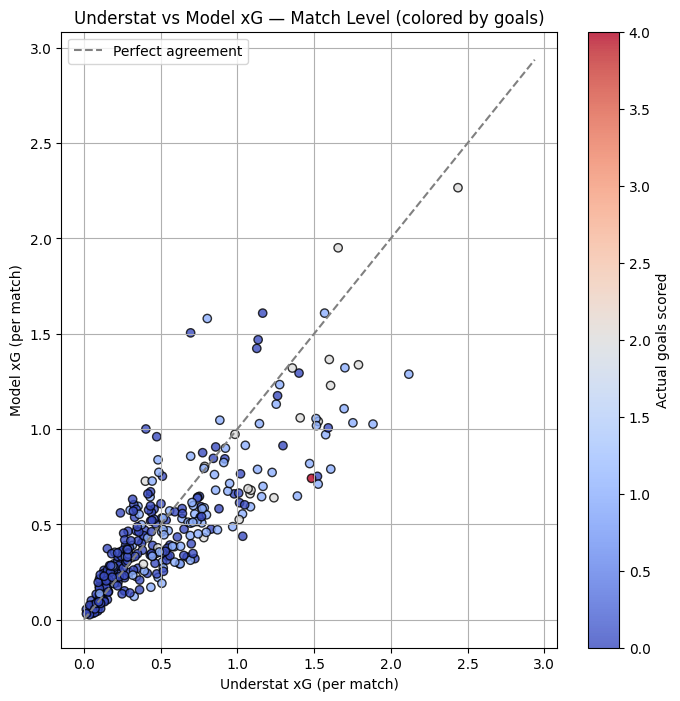

In [126]:
# ============================================================
# SCATTER: UNDERSTAT vs MODEL (COLOR BY GOALS) + CORRELATIONS
# ============================================================
# WHAT:    Visualize agreement with Understat per match and quantify with r/ρ.
# WHY:     Quick read on systematic bias & rank ordering.
# HOW:     Scatter with 45° line; color points by actual goals; compute Pearson/Spearman.
# ============================================================

from scipy.stats import pearsonr, spearmanr

match_id_col = "game_id"
understat_xg_col = "xg"
understat_goal_col = "goal_flag"

missing = [c for c in [match_id_col, understat_xg_col, understat_goal_col, "model_xG_with_pen"] if c not in df_shots.columns]
if missing:
    print("⚠️ Missing expected columns in df_shots:", missing)
else:
    scatter_df = (
        df_shots.groupby(match_id_col)
        .agg(
            understat_xG = (understat_xg_col, "sum"),
            model_xG     = ("model_xG_with_pen", "sum"),
            goals        = (understat_goal_col, "sum")
        )
        .reset_index()
    )

    # Correlations
    pear_corr, pear_p = pearsonr(scatter_df["understat_xG"], scatter_df["model_xG"])
    spear_corr, spear_p = spearmanr(scatter_df["understat_xG"], scatter_df["model_xG"])
    print(f"Pearson r:  {pear_corr:.3f} (p={pear_p:.3g})")
    print(f"Spearman ρ: {spear_corr:.3f} (p={spear_p:.3g})")

    # Plot
    plt.figure(figsize=(8,8))
    sc = plt.scatter(
        scatter_df["understat_xG"],
        scatter_df["model_xG"],
        c=scatter_df["goals"],
        cmap="coolwarm",
        edgecolor="k",
        alpha=0.8
    )
    max_val = max(scatter_df["understat_xG"].max(), scatter_df["model_xG"].max()) + 0.5
    plt.plot([0, max_val], [0, max_val], linestyle='--', color='gray', label="Perfect agreement")
    plt.xlabel("Understat xG (per match)")
    plt.ylabel("Model xG (per match)")
    plt.title("Understat vs Model xG — Match Level (colored by goals)")
    plt.legend()
    cbar = plt.colorbar(sc)
    cbar.set_label("Actual goals scored")
    plt.grid(True)
    plt.show()


In [127]:
# ============================================================
# SAVE ARTIFACTS & MODEL CARD
# ============================================================
# WHAT:    Persist tuned pipeline, calibrated model, and metadata.
# WHY:     Reproducibility, deployment, and auditing.
# HOW:     joblib.dump() for models; JSON card with key training details.
# ============================================================

from datetime import datetime
import json

os.makedirs(SAVE_DIR, exist_ok=True)
joblib.dump(best_pipe, os.path.join(SAVE_DIR, "xg_lr_bestpipe.joblib"))
joblib.dump(cal,       os.path.join(SAVE_DIR, "xg_lr_calibrated.joblib"))

# Ensure best_C is defined from grid search if not already
if 'best_C' not in locals():
    best_C = gs.best_params_["clf__C"]

model_card = {
    "generated_at": datetime.utcnow().isoformat() + "Z",
    "random_state": RANDOM_STATE,
    "penalty": "l2",
    "solver": "saga",
    "best_C": float(best_C),
    "features_numeric": num_cols,
    "features_categorical": cat_cols,
    "calibration": "isotonic on hold-out validation",
    "split": {
        "outer": "GroupShuffleSplit (70/30 trainval/test by match)",
        "inner_val": "GroupShuffleSplit (trainval -> train/val)",
        "cv_oof": "StratifiedGroupKFold(n_splits=5)"
    },
    "penalty_xg_constant": PEN_XG_CONST
}
with open(os.path.join(SAVE_DIR, "model_card.json"), "w") as f:
    json.dump(model_card, f, indent=2)

print("Saved artifacts to:", SAVE_DIR)


[08/14/25 12:14:05] WARNING  C:\Users\paulo\AppData\Local\Temp\ipykernel_20376\13884672.py:21:      ]8;id=68945;file://C:\Users\paulo\miniconda3\Lib\warnings.py\warnings.py]8;;\:]8;id=142181;file://C:\Users\paulo\miniconda3\Lib\warnings.py#112\112]8;;\
                             DeprecationWarning: datetime.datetime.utcnow() is deprecated and                      
                             scheduled for removal in a future version. Use timezone-aware objects                 
                             to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).                   
                               "generated_at": datetime.utcnow().isoformat() + "Z",                                
                                                                                                                   

Saved artifacts to: artifacts/xg_model_ligue1
